# Amazon Fine Food Reviews Analysis using TSNE


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
We, convert the text into vectors by using different techniques like. Bag of words(BOW), uni-gram, bi-gram, w2vec, avg w2vec. once we convert this text into vectors we apply T-SNE to visualize the data.




## Importing modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\hp\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 1. Loading data


In [2]:
con = sqlite3.connect('database.sqlite')

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""",con)
#The above code takes 5000k reviews
def partition(x):
    if x < 3:
        return 0
    return 1
    
actual_score = filtered_data['Score']
positivenegative = actual_score.map(partition)
filtered_data['Score'] = positivenegative
print('Total no of data points is', filtered_data.shape)
print(filtered_data.head(3))

Total no of data points is (5000, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)
print(display.head())
print(display.shape)

#This code says collect the data and group them such a way that,
#if any user has same ProductId, ProfileName, Time, Score, Text, more than one time group them under one user ID.

               UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2  
(80668, 7)


In [4]:
x = pd.read_sql_query("""SELECT * FROM Reviews WHERE UserId = 'AZYMD9P9F9UZ6' """,con)
x
# printing a sample user-Id reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,35393,B000GW46D4,AZYMD9P9F9UZ6,W. Coombe,0,0,5,1239148800,Good Jerky,I like the peppered flavor a lot better than t...
1,35394,B000GW46D4,AZYMD9P9F9UZ6,W. Coombe,0,0,4,1239062400,Nice flavor,"I like the quality of Jack Link products, this..."
2,35395,B000GW46D4,AZYMD9P9F9UZ6,W. Coombe,0,0,4,1238630400,Good Jerky,I like the peppered flavor a lot better than t...
3,88656,B000PMJLJO,AZYMD9P9F9UZ6,W. Coombe,0,0,5,1239148800,Good Jerky,I like the peppered flavor a lot better than t...
4,88657,B000PMJLJO,AZYMD9P9F9UZ6,W. Coombe,0,0,4,1239062400,Nice flavor,"I like the quality of Jack Link products, this..."
5,88658,B000PMJLJO,AZYMD9P9F9UZ6,W. Coombe,0,0,4,1238630400,Good Jerky,I like the peppered flavor a lot better than t...
6,183035,B000PMHLZK,AZYMD9P9F9UZ6,W. Coombe,0,0,5,1239148800,Good Jerky,I like the peppered flavor a lot better than t...
7,183036,B000PMHLZK,AZYMD9P9F9UZ6,W. Coombe,0,0,4,1239062400,Nice flavor,"I like the quality of Jack Link products, this..."
8,183037,B000PMHLZK,AZYMD9P9F9UZ6,W. Coombe,0,0,4,1238630400,Good Jerky,I like the peppered flavor a lot better than t...
9,201316,B000GW46DE,AZYMD9P9F9UZ6,W. Coombe,0,0,5,1239148800,Good Jerky,I like the peppered flavor a lot better than t...


# 2. Data cleaning

In [5]:
Display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId = 'AR5J8UI46CURR'
ORDER BY ProductId
""",con)
Display.head()

# In this code we are removing all the reviews that  has Score = 3, and we  print a user-id review where the review for 
# a given product is taken by the other products.

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [27]:
#sorting data
sorted_data= filtered_data.sort_values('ProductId', axis = 0,ascending = True, inplace = False, kind = 'quicksort', na_position = 'last')

In [28]:
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep ='first',inplace =False)
print(final.shape)
# This code will remove all the duplicated reviews and just keep the original revie

(4986, 10)


In [29]:
print(final['UserId'].size*1.0)
(final['UserId'].size*1.0/filtered_data['UserId'].size*1.0)*100
# This gives the shape of the data after removing the duplicates

4986.0


99.72

In [30]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE HelpfulnessNumerator > HelpfulnessDenominator
""",con)
display
# This code shows the reviews that has high score for the HelpfulnessNumerator that the HelpfulnessDenominator, which is
# incorrect data.

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [31]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape


(4986, 10)

In [32]:
print(final['UserId'].size*1.0)
(final['UserId'].size*1.0/filtered_data['UserId'].size*1.0)*100

4986.0


99.72

### Sample Text

In [33]:
print(final['Text'][0],"="*50)
sent_0 = final['Text'].values
print(sent_0)
# 

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most. ==================================================
['Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.'
 "We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!"
 "I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I

##### The above code prints the a review from the data.
##### We can clearly observe some URL tags and Http links
##### For better analysis of the data we need to remove the non informative text

# 3. Text Preprocessing
1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

In [34]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


In [35]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [36]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [43]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████| 4986/4986 [00:01<00:00, 2643.93it/s]


## 3.2 Text preprocessing for summary

In [44]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop_words)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████████| 4986/4986 [00:01<00:00, 4122.83it/s]


In [52]:
print(preprocessed_summary[0])

thirty bucks


# 4 Featurization

## 4.1 BAG OF WORDS


In [39]:
countvector = CountVectorizer()
countvector.fit(preprocessed_reviews)
print('Some feature names',countvector.get_feature_names()[:10])
print('========'*15)
bag_of_words = countvector.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(bag_of_words))
print("Shape of the data",bag_of_words.shape)
print('========')
print("the number of unique words ", bag_of_words.shape[1])

Some feature names ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
Shape of the data (4986, 12997)
the number of unique words  12997


## 4.2 Bi-Grams and n- Grams

In [43]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)


## TF-IDF

In [46]:
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2),min_df = 10)
final_tf_idf =tf_idf_vect.fit_transform(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## W2Vec

In [52]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())


In [60]:
w2v_model= Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('alternative', 0.9953811168670654), ('regular', 0.9950040578842163), ('healthier', 0.9946224689483643), ('popchips', 0.9944634437561035), ('care', 0.9943244457244873), ('bad', 0.9940134286880493), ('calorie', 0.9940084218978882), ('satisfying', 0.9938516616821289), ('lovers', 0.9936150908470154), ('salty', 0.99360591173172)]
[('frozen', 0.9993442296981812), ('start', 0.9993373155593872), ('choice', 0.9993250966072083), ('popcorn', 0.9993075132369995), ('beef', 0.9993061423301697), ('soup', 0.999300479888916), ('type', 0.999296247959137), ('hands', 0.9992851614952087), ('beans', 0.9992777109146118), ('peanuts', 0.999272346496582)]


In [61]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## Avg W2v

In [65]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


100%|████████████████████████████████████| 4986/4986 [00:04<00:00, 1180.14it/s]


4986
50


## TFIDF weighted W2v

In [66]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [68]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 4986/4986 [00:22<00:00, 226.63it/s]


# visualizing the above techniques using T-SNE

## Applying TNSE on Text BOW vectors

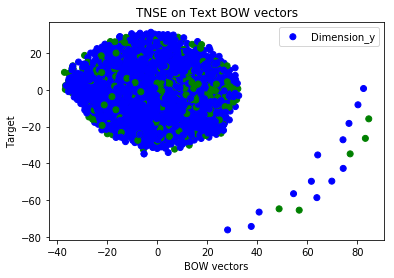

In [83]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

x =  bag_of_words
x.toarray()

y = final['Score']

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())

for_tsne = np.hstack((X_embedding, y.values.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'green', 1:'blue'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.xlabel('BOW vectors')
plt.ylabel('Target')
plt.legend()
plt.title('TNSE on Text BOW vectors')
plt.show()

#### From the above plot we can say that there are few outliers, and the positive and negative reviews are grouped in a cluster form

## Applying TNSE on Text TFIDF vectors

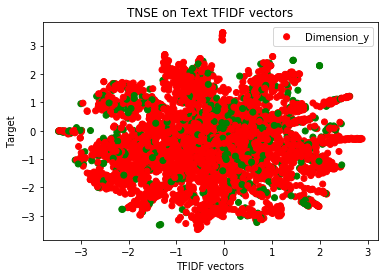

In [84]:
x =  final_tf_idf

y = final['Score']

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())

for_tsne = np.hstack((X_embedding, y.values.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'green', 1:'red'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.xlabel('TFIDF vectors')
plt.ylabel('Target')
plt.legend()
plt.title('TNSE on Text TFIDF vectors')
plt.show()

#### From the above plot we can say that positive and negative reviews are distributed randomly in a cluster form. It seems like we cannot seperate the cluster linearly

## Applying TNSE on Text Avg W2V vectors

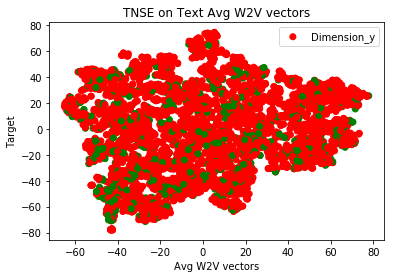

In [89]:
x =  sent_vectors

y = final['Score']

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)

for_tsne = np.hstack((X_embedding, y.values.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'green', 1:'red'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.xlabel('Avg W2V vectors')
plt.ylabel('Target')
plt.legend()
plt.title('TNSE on Text Avg W2V vectors')
plt.show()

#### In the above plot the positive and negative reviews are more uniformly distributed with in the cluster

## Applying TNSE on Text TFIDF weighted W2V vectors

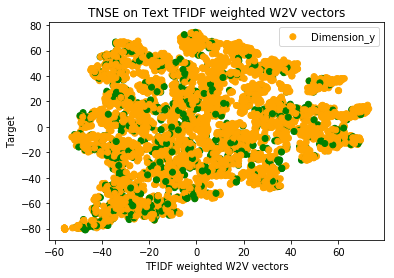

In [90]:
x = tfidf_sent_vectors

y = final['Score']

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)

for_tsne = np.hstack((X_embedding, y.values.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'green', 1:'orange'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.xlabel('TFIDF weighted W2V vectors')
plt.ylabel('Target')
plt.legend()
plt.title('TNSE on Text TFIDF weighted W2V vectors')
plt.show()


#### The positive and negative points are well distributed within the cluster

## Observation
     1) The T-SNE visulization presented a better insight of how the data is distributed.
     2) T-SNE enable use view the high dimentional data in 2D plot, which retrives better information than any Dimentional 
        reduction technique.
     3) The plot on "TNSE on Text BOW vectors" shows there are some outlier in the dataset.
     4) The other plots formed a well mixture of positive and negative data points.